In [6]:
import pandas as pd

# Charger les données
df = pd.read_csv("full_grouped.csv")  

# Renommer les colonnes pour simplifier
df = df.rename(columns={
    'Date': 'Date',
    'Country/Region': 'Country',
    'Confirmed': 'Confirmed',
    'Deaths': 'Deaths',
    'Recovered': 'Recovered',
    'New cases': 'New cases',
    'New deaths': 'New deaths',
    'New recovered': 'New recovered'
})

# Convertir la date et créer une colonne mois
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()

# Garder uniquement les colonnes nécessaires
df = df[['Month', 'Country', 'Confirmed', 'Deaths', 'Recovered',
         'New cases', 'New deaths', 'New recovered']]

# Convertir les colonnes temporelles en valeurs absolues
for col in ['New cases', 'New deaths', 'New recovered']:
    df[col] = df[col].abs()

# Grouper par mois et pays
df_grouped = df.groupby(['Month', 'Country'], as_index=False).agg({
    'Confirmed': 'last',
    'Deaths': 'last',
    'Recovered': 'last',
    'New cases': 'sum',
    'New deaths': 'sum',
    'New recovered': 'sum'
})

# Ajouter une colonne Id auto-incrémentée
df_grouped.insert(0, 'Id', range(1, len(df_grouped) + 1))

# Ajouter une colonne 'nom' avec la valeur 'COVID-19' au début du DataFrame
df_grouped.insert(1, 'Name', 'COVID-19')

# Vérifier la cohérence des données
if df.isnull().any().any():
    print("Les données contiennent des valeurs nulles. Vérifiez le fichier source.")

# Vérifier que les colonnes numériques ne contiennent pas de valeurs négatives
for col in ['Confirmed', 'Deaths', 'Recovered', 'New cases', 'New deaths', 'New recovered']:
    if (df[col] < 0).any():
        print(f"La colonne '{col}' contient des valeurs négatives.")

# Vérifier que les colonnes nécessaires sont présentes
required_columns = ['Month', 'Country', 'Confirmed', 'Deaths', 'Recovered', 'New cases', 'New deaths', 'New recovered']
for col in required_columns:
    if col not in df.columns:
        print(f"La colonne requise '{col}' est manquante dans les données.")

MARGIN = 100  # Tolérance pour les incohérences
# Vérification des incohérences
# Initialiser une liste pour stocker les incohérences
inconsistencies = []

# Vérification des incohérences dans les données
# Parcourir chaque pays et vérifier les incohérences
for country, group in df_grouped.groupby('Country'):
    group = group.sort_values('Month').reset_index(drop=True)


    for i in range(1, len(group)):
        current = group.iloc[i]
        prev = group.iloc[i - 1]

        # Vérification décès
        expected_deaths = prev['Deaths'] + current['New deaths']
        if abs(current['Deaths'] - expected_deaths) > MARGIN:
            print(f"⚠️ Incohérence pour '{country}' au mois de {current['Month']} [Deaths]: "
                  f"{current['Deaths']} ≠ {prev['Deaths']} + {current['New deaths']} (tolérance ±{MARGIN})")
            inconsistencies.append({
                'Country': country,
                'Month': current['Month'],
                'Field': 'Deaths',
                'Actual': current['Deaths'],
                'Expected': expected_deaths
            })

        # Vérification cas confirmés
        expected_confirmed = prev['Confirmed'] + current['New cases']
        if abs(current['Confirmed'] - expected_confirmed) > MARGIN:
            print(f"⚠️ Incohérence pour '{country}' au mois de {current['Month']} [Confirmed]: "
                  f"{current['Confirmed']} ≠ {prev['Confirmed']} + {current['New cases']} (tolérance ±{MARGIN})")
            inconsistencies.append({
                'Country': country,
                'Month': current['Month'],
                'Field': 'Confirmed',
                'Actual': current['Confirmed'],
                'Expected': expected_confirmed
            })

        # Vérification récupérations
        expected_recovered = prev['Recovered'] + current['New recovered']
        if abs(current['Recovered'] - expected_recovered) > MARGIN:
            print(f"⚠️ Incohérence pour '{country}' au mois de {current['Month']} [Recovered]: "
                  f"{current['Recovered']} ≠ {prev['Recovered']} + {current['New recovered']} (tolérance ±{MARGIN})")
            inconsistencies.append({
                'Country': country,
                'Month': current['Month'],
                'Field': 'Recovered',
                'Actual': current['Recovered'],
                'Expected': expected_recovered
            })


inconsistencies_df = pd.DataFrame(inconsistencies)
inconsistencies_df.head()

# Sauvegarder le résultat dans le répertoire courant
df_grouped.to_csv("data_etl_output.csv", index=False)

print("\nETL terminé. Fichier sauvegardé sous : data_etl_output.csv")

⚠️ Incohérence pour 'Algeria' au mois de 2020-03-01 00:00:00 [Recovered]: 46 ≠ 0 + 200 (tolérance ±100)
⚠️ Incohérence pour 'Benin' au mois de 2020-05-01 00:00:00 [Confirmed]: 232 ≠ 64 + 377 (tolérance ±100)
⚠️ Incohérence pour 'China' au mois de 2020-04-01 00:00:00 [Recovered]: 76951 ≠ 74645 + 4006 (tolérance ±100)
⚠️ Incohérence pour 'Cote d'Ivoire' au mois de 2020-06-01 00:00:00 [Recovered]: 4273 ≠ 1435 + 3460 (tolérance ±100)
⚠️ Incohérence pour 'Ecuador' au mois de 2020-05-01 00:00:00 [Confirmed]: 39098 ≠ 24934 + 17277 (tolérance ±100)
⚠️ Incohérence pour 'Finland' au mois de 2020-05-01 00:00:00 [Recovered]: 5500 ≠ 3000 + 2900 (tolérance ±100)
⚠️ Incohérence pour 'France' au mois de 2020-04-01 00:00:00 [Confirmed]: 167299 ≠ 52827 + 119170 (tolérance ±100)
⚠️ Incohérence pour 'France' au mois de 2020-05-01 00:00:00 [Deaths]: 28805 ≠ 24379 + 4860 (tolérance ±100)
⚠️ Incohérence pour 'France' au mois de 2020-05-01 00:00:00 [Confirmed]: 189009 ≠ 167299 + 22095 (tolérance ±100)
⚠️ Inco

Résultats du modèle:
RMSE: 83529.38
R²: 0.9540


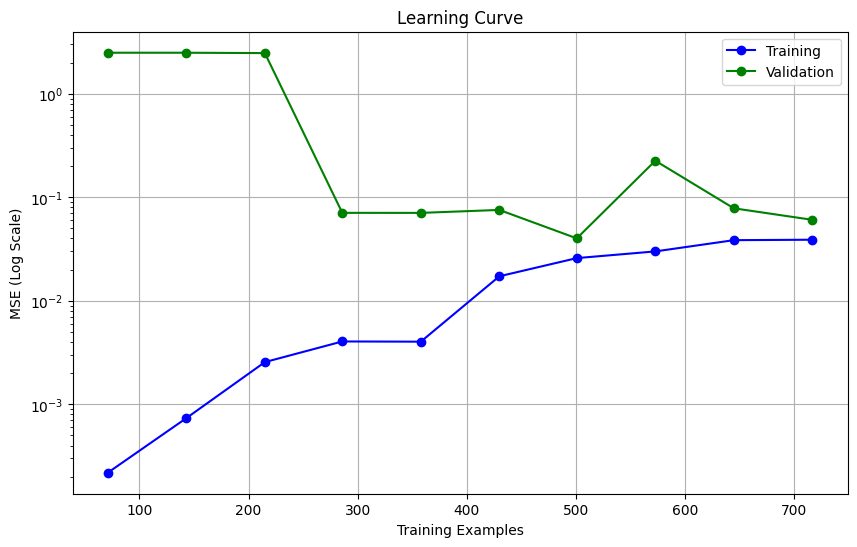

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour charger et préparer les données
def load_and_preprocess_data():
    """Charge et prépare les données"""
    df = pd.read_csv("data_etl_output.csv")
    df = df.drop_duplicates()
    df['Confirmed_lag1'] = df.groupby('Country')['Confirmed'].shift(1)
    return df.dropna()

# Fonction pour entraîner le modèle
def train_model(X_train, y_train):
    """Entraîne le modèle de régression linéaire"""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

# Fonction pour évaluer le modèle
def evaluate_model(model, X_test, y_test, y_scaler):
    """Évalue le modèle et retourne les métriques"""
    y_pred = model.predict(X_test)
    y_pred_original = y_scaler.inverse_transform(y_pred)
    y_test_original = y_scaler.inverse_transform(y_test)
    
    return {
        'rmse': np.sqrt(mean_squared_error(y_test_original, y_pred_original)),
        'r2': r2_score(y_test_original, y_pred_original),
        'model': model,
        'y_pred': y_pred_original,
        'y_test': y_test_original,
        'y_scaler': y_scaler
    }

# Fonction pour générer la learning curve
def generate_learning_curve(model, X_train, y_train):
    """Génère et sauvegarde la learning curve"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(.1, 1.0, 10),
        scoring='neg_mean_squared_error',
        shuffle=False
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="blue", label="Training")
    plt.plot(train_sizes, -np.mean(test_scores, axis=1), 'o-', color="green", label="Validation")
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("MSE (Log Scale)")
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.savefig("learning_curve.png")
    plt.show()
    plt.close()

# Exécution du modèle
# 1. Chargement et préparation des données
df = load_and_preprocess_data()
X = df[['Confirmed_lag1']]
y = df['Confirmed'].values.reshape(-1, 1)

# 2. Normalisation
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# 3. Entraînement du modèle
model = train_model(X_train, y_train)

# 4. Évaluation
results = evaluate_model(model, X_test, y_test, y_scaler)

# 5. Affichage des résultats
print("Résultats du modèle:")
print(f"RMSE: {results['rmse']:.2f}")
print(f"R²: {results['r2']:.4f}")

# 6. Génération de la learning curve
generate_learning_curve(model, X_train, y_train)

2025/06/01 19:43:32 INFO mlflow.tracking.fluent: Experiment with name 'COVID_Linear_Regression' does not exist. Creating a new experiment.
2025/06/01 19:43:32 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
  

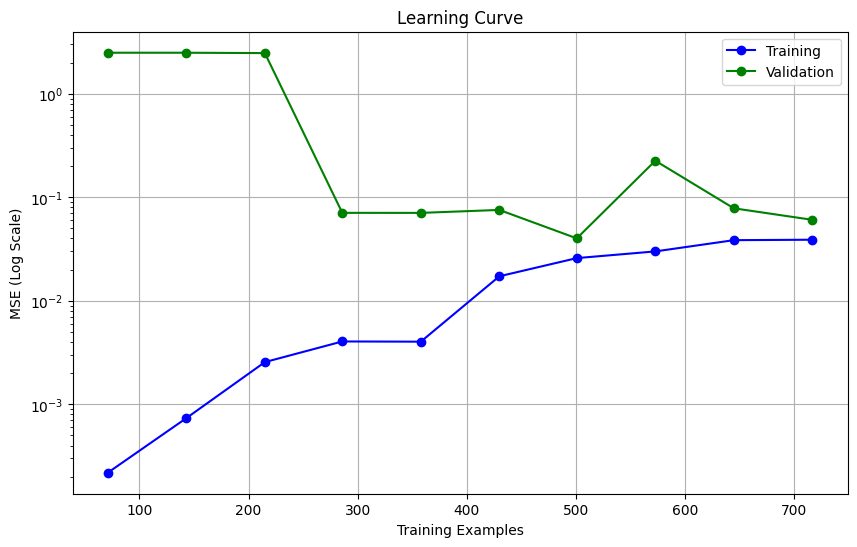

Tracking MLflow terminé avec succès!
Run ID: 4c47c632f9a446a3b214b887fb86b4aa


In [3]:
import mlflow
import mlflow.sklearn
import os

# Configuration de MLflow
mlflow.set_experiment("COVID_Linear_Regression")

# Démarrer un run MLflow
with mlflow.start_run():
    # 1. Log du modèle
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="covid_model",
        registered_model_name="COVID_Linear_Regression"
    )
    
    # 2. Log des paramètres
    mlflow.log_params({
        "test_size": 0.2,
        "random_state": 42,
        "features": "Confirmed_lag1",
        "normalization": "StandardScaler",
        "model_type": "LinearRegression"
    })
    
    # 3. Log des métriques
    mlflow.log_metrics({
        "rmse": results['rmse'],
        "r2_score": results['r2']
    })
    
    # 4. Log des artefacts
    # On regénère la courbe d'apprentissage pour être sûr qu'elle existe
    generate_learning_curve(model, X_train, y_train)
    mlflow.log_artifact("learning_curve.png")
    
    # 5. Log des informations supplémentaires
    mlflow.set_tag("data_source", "data_etl_output.csv")
    mlflow.set_tag("mlflow.note.content", "Modèle de prédiction des cas COVID avec lag1")
    
    # 6. Nettoyage
    if os.path.exists("learning_curve.png"):
        os.remove("learning_curve.png")
    
    print("Tracking MLflow terminé avec succès!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Charger les données
df = pd.read_csv("data_etl_output.csv")

# Créer des colonnes décalées pour les prédictions
for col in ['Confirmed', 'Deaths', 'Recovered']:
    df[f'{col}_lag1'] = df.groupby('Country')[col].shift(1)

# Supprimer les lignes avec des valeurs manquantes dues au décalage
df = df.dropna()

# Encoder les pays
le = LabelEncoder()
df['Country_encoded'] = le.fit_transform(df['Country'])

# Définir les features et la target
features = ['Confirmed_lag1', 'Deaths_lag1', 'Recovered_lag1', 'Country_encoded']
targets = ['Confirmed', 'Deaths', 'Recovered']

X = df[features]
y = df[targets]

#load the dataset 


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [5]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train, y_train)

rfr_rmse_confirmed = np.sqrt(mean_squared_error(y_test['Confirmed'], rfr_model.predict(X_test)[:, 0]))
rfr_rmse_deaths = np.sqrt(mean_squared_error(y_test['Deaths'], rfr_model.predict(X_test)[:, 1]))
rfr_rmse_recovered = np.sqrt(mean_squared_error(y_test['Recovered'], rfr_model.predict(X_test)[:, 2]))

print("Random Forest Regressor RMSE:")
print(f"Confirmed: {rfr_rmse_confirmed}, Deaths: {rfr_rmse_deaths}, Recovered: {rfr_rmse_recovered}")

# Gradient Boosting Regressor with MultiOutputRegressor
gbr_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gbr_model.fit(X_train, y_train)

# Predictions with Gradient Boosting
gbr_y_pred = gbr_model.predict(X_test)

# Calculate RMSE for Gradient Boosting
gbr_rmse_confirmed = np.sqrt(mean_squared_error(y_test['Confirmed'], gbr_y_pred[:, 0]))
gbr_rmse_deaths = np.sqrt(mean_squared_error(y_test['Deaths'], gbr_y_pred[:, 1]))
gbr_rmse_recovered = np.sqrt(mean_squared_error(y_test['Recovered'], gbr_y_pred[:, 2]))

print("Gradient Boosting Regressor RMSE:")
print(f"Confirmed: {gbr_rmse_confirmed}, Deaths: {gbr_rmse_deaths}, Recovered: {gbr_rmse_recovered}")

# Linear Regression with MultiOutputRegressor
lr_model = MultiOutputRegressor(LinearRegression())
lr_model.fit(X_train, y_train)

# Predictions with Linear Regression
lr_y_pred = lr_model.predict(X_test)

# Calculate RMSE for Linear Regression
lr_rmse_confirmed = np.sqrt(mean_squared_error(y_test['Confirmed'], lr_y_pred[:, 0]))
lr_rmse_deaths = np.sqrt(mean_squared_error(y_test['Deaths'], lr_y_pred[:, 1]))
lr_rmse_recovered = np.sqrt(mean_squared_error(y_test['Recovered'], lr_y_pred[:, 2]))

print("Linear Regression RMSE:")
print(f"Confirmed: {lr_rmse_confirmed}, Deaths: {lr_rmse_deaths}, Recovered: {lr_rmse_recovered}")

print("\nRMSE scores:")
# score r2 random forest
from sklearn.metrics import r2_score
rfr_r2_confirmed = r2_score(y_test['Confirmed'], rfr_model.predict(X_test)[:, 0])
rfr_r2_deaths = r2_score(y_test['Deaths'], rfr_model.predict(X_test)[:, 1])
rfr_r2_recovered = r2_score(y_test['Recovered'], rfr_model.predict(X_test)[:, 2])
print("Random Forest Regressor R2:")
print(f"Confirmed: {rfr_r2_confirmed}, Deaths: {rfr_r2_deaths}, Recovered: {rfr_r2_recovered}")

# score r2 gradient boosting
gbr_r2_confirmed = r2_score(y_test['Confirmed'], gbr_y_pred[:, 0])
gbr_r2_deaths = r2_score(y_test['Deaths'], gbr_y_pred[:, 1])
gbr_r2_recovered = r2_score(y_test['Recovered'], gbr_y_pred[:, 2])
print("Gradient Boosting Regressor R2:")
print(f"Confirmed: {gbr_r2_confirmed}, Deaths: {gbr_r2_deaths}, Recovered: {gbr_r2_recovered}")
# score r2 linear regression
lr_r2_confirmed = r2_score(y_test['Confirmed'], lr_y_pred[:, 0])
lr_r2_deaths = r2_score(y_test['Deaths'], lr_y_pred[:, 1])
lr_r2_recovered = r2_score(y_test['Recovered'], lr_y_pred[:, 2])
print("Linear Regression R2:")
print(f"Confirmed: {lr_r2_confirmed}, Deaths: {lr_r2_deaths}, Recovered: {lr_r2_recovered}")


Random Forest Regressor RMSE:
Confirmed: 56527.16753956689, Deaths: 3834.3655447739757, Recovered: 24347.824072305015
Gradient Boosting Regressor RMSE:
Confirmed: 80006.05882751447, Deaths: 2277.7988713673626, Recovered: 30805.492485565373
Linear Regression RMSE:
Confirmed: 55424.770449724325, Deaths: 2546.7357102811775, Recovered: 41015.71417962562

RMSE scores:
Random Forest Regressor R2:
Confirmed: 0.8119107871463432, Deaths: 0.6582321397024737, Recovered: 0.9115087087356599
Gradient Boosting Regressor R2:
Confirmed: 0.6232136209458147, Deaths: 0.879392326705786, Recovered: 0.8583434910243496
Linear Regression R2:
Confirmed: 0.8191755110616415, Deaths: 0.8492310367278771, Recovered: 0.7488803031944753


In [6]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve

# 1. Initialisation de l'expérience
experiment_name = "COVID-19_Predictions_V2"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# 2. Fonction pour générer les artefacts
def generate_artifacts(model, model_name, X_train, y_train, rmse_values, r2_values):
    """Génère et enregistre tous les artefacts pour un modèle"""
    # Heatmap RMSE
    plt.figure(figsize=(8, 3))
    sns.heatmap([rmse_values], annot=True, fmt=".2f", 
                xticklabels=['Confirmed', 'Deaths', 'Recovered'],
                cmap="YlOrRd")
    plt.title(f"RMSE - {model_name}")
    mlflow.log_figure(plt.gcf(), f"rmse_heatmap.png")
    plt.close()
    
    # Heatmap R2
    plt.figure(figsize=(8, 3))
    sns.heatmap([r2_values], annot=True, fmt=".2f",
                xticklabels=['Confirmed', 'Deaths', 'Recovered'],
                cmap="YlGnBu", vmin=-1, vmax=1)
    plt.title(f"R² - {model_name}")
    mlflow.log_figure(plt.gcf(), f"r2_heatmap.png")
    plt.close()
    
    # Feature Importance (si applicable)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 3))
        sns.barplot(x=X_train.columns, y=model.feature_importances_)
        plt.title(f"Feature Importance - {model_name}")
        mlflow.log_figure(plt.gcf(), f"feature_importance.png")
        plt.close()
    elif model_name == "GradientBoosting":  # Cas spécifique pour MultiOutputRegressor
        try:
            plt.figure(figsize=(10, 3))
            sns.barplot(x=X_train.columns, y=model.estimators_[0].feature_importances_)
            plt.title(f"Feature Importance - {model_name} (First Target)")
            mlflow.log_figure(plt.gcf(), f"feature_importance.png")
            plt.close()
        except Exception as e:
            print(f"Could not generate feature importance for {model_name}: {str(e)}")

# 3. Fonction pour créer les heatmaps globales
def create_global_heatmaps():
    """Crée et enregistre les heatmaps comparatives de tous les modèles"""
    models = ['RandomForest', 'GradientBoosting', 'LinearRegression']
    
    # RMSE global
    rmse_data = np.array([
        [rfr_rmse_confirmed, rfr_rmse_deaths, rfr_rmse_recovered],
        [gbr_rmse_confirmed, gbr_rmse_deaths, gbr_rmse_recovered],
        [lr_rmse_confirmed, lr_rmse_deaths, lr_rmse_recovered]
    ])
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(rmse_data, annot=True, fmt=".2f",
                xticklabels=['Confirmed', 'Deaths', 'Recovered'],
                yticklabels=models,
                cmap="YlOrRd")
    plt.title("Comparaison globale des RMSE")
    mlflow.log_figure(plt.gcf(), "global_rmse_comparison.png")
    plt.close()
    
    # R2 global
    r2_data = np.array([
        [rfr_r2_confirmed, rfr_r2_deaths, rfr_r2_recovered],
        [gbr_r2_confirmed, gbr_r2_deaths, gbr_r2_recovered],
        [lr_r2_confirmed, lr_r2_deaths, lr_r2_recovered]
    ])
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(r2_data, annot=True, fmt=".2f",
                xticklabels=['Confirmed', 'Deaths', 'Recovered'],
                yticklabels=models,
                cmap="YlGnBu", vmin=-1, vmax=1)
    plt.title("Comparaison globale des R²")
    mlflow.log_figure(plt.gcf(), "global_r2_comparison.png")
    plt.close()

# 4. Fonction pour logger un modèle
def log_model_run(model, model_name, metrics, X_train, y_train):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_metrics(metrics)
        generate_artifacts(model, model_name, X_train, y_train,
                         [metrics['rmse_confirmed'], metrics['rmse_deaths'], metrics['rmse_recovered']],
                         [metrics['r2_confirmed'], metrics['r2_deaths'], metrics['r2_recovered']])
        mlflow.sklearn.log_model(model, "model")

# 5. Exécution principale
# D'abord les visualisations globales dans un run dédié
with mlflow.start_run(run_name="Global_Visualizations"):
    create_global_heatmaps()

# Puis les runs pour chaque modèle
models_data = {
    "RandomForest": {
        "model": rfr_model,
        "metrics": {
            "rmse_confirmed": rfr_rmse_confirmed,
            "rmse_deaths": rfr_rmse_deaths,
            "rmse_recovered": rfr_rmse_recovered,
            "r2_confirmed": rfr_r2_confirmed,
            "r2_deaths": rfr_r2_deaths,
            "r2_recovered": rfr_r2_recovered
        }
    },
    "GradientBoosting": {
        "model": gbr_model,
        "metrics": {
            "rmse_confirmed": gbr_rmse_confirmed,
            "rmse_deaths": gbr_rmse_deaths,
            "rmse_recovered": gbr_rmse_recovered,
            "r2_confirmed": gbr_r2_confirmed,
            "r2_deaths": gbr_r2_deaths,
            "r2_recovered": gbr_r2_recovered
        }
    },
    "LinearRegression": {
        "model": lr_model,
        "metrics": {
            "rmse_confirmed": lr_rmse_confirmed,
            "rmse_deaths": lr_rmse_deaths,
            "rmse_recovered": lr_rmse_recovered,
            "r2_confirmed": lr_r2_confirmed,
            "r2_deaths": lr_r2_deaths,
            "r2_recovered": lr_r2_recovered
        }
    }
}

for model_name, data in models_data.items():
    log_model_run(data["model"], model_name, data["metrics"], X_train, y_train)

print("✅ MLflow logging completed!")
print(f"Pour visualiser les résultats")

2025/06/01 19:43:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/01 19:43:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/01 19:43:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow logging completed!
Pour visualiser les résultats


In [7]:
# Créer le pickle pour le modèle Random Forest
import pickle
with open('./model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

FileNotFoundError: [Errno 2] No such file or directory: '../api/model.pkl'